In [27]:
import os
import torch
from tqdm import tqdm
import numpy as np

In [28]:
assert torch.cuda.is_available(), 'CUDA is not correctly installed!!'
print(torch.tensor([2.0, 3.0, 1.0]).cuda())
property = torch.cuda.get_device_properties(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tensor([2., 3., 1.], device='cuda:0')


In [29]:
print('====== Your GPU info ======')
print('name:\t\t', property.name)
print('capability:\t', 'v{}.{}'.format(property.major, property.minor))
print('memory:\t\t', round(property.total_memory / 1e9), 'Gb')
print('processors:\t', property.multi_processor_count)

====== Your GPU info ======
name:		 Tesla T4
capability:	 v7.5
memory:		 16 Gb
processors:	 40


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# LOAD AND SPLIT DATASET HERE

# Load headers
csv_path = "dataset_v2.csv"

with open(csv_path, 'r', newline='') as csv_fh:
    headers = csv_fh.readline().strip().split(',')
    
    
label_col = "Price"
date_col = "Date(UTC)"
# Load features and labels
x_cols = [i for i in range(len(headers)) if (headers[i] != label_col and headers[i] != date_col)]
l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
prices = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

inputs = np.delete(inputs, -1, axis=0)
print(inputs.shape)

# add intercept
new_x = np.zeros((inputs.shape[0], inputs.shape[1] + 1), dtype=inputs.dtype)
new_x[:, 0] = 1
new_x[:, 1:] = inputs

inputs = new_x
print(inputs.shape)

diff = np.diff(prices)
labels = np.where(diff > 0, 1, 0)
print(labels.shape)
print(labels)

# Feature engineering
norm = MinMaxScaler().fit(inputs)
inputs = norm.transform(inputs)

# apply standardization on numerical features
for i in range(inputs.shape[1]):
    
    # fit on training data column
    scale = StandardScaler().fit(inputs[[i]])
    
    # transform the training data column
    inputs[i] = scale.transform(inputs[[i]])


X_train, X_test, y_train,  y_test = train_test_split(
    inputs, labels, test_size=0.1, random_state=42)


(2462, 15)
(2462, 16)
(2462,)
[0 0 1 ... 0 1 0]


In [31]:
import torch.nn.functional as F

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.layer1 = torch.nn.Linear(input_dim,50)
        self.layer2 = torch.nn.Linear(50, 10)
        self.layer3 = torch.nn.Linear(10, output_dim)
        
    def forward(self, x):
        x = torch.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        x = torch.sigmoid(self.layer3(x)) # To check with the loss function
        return x

In [32]:
epochs = 1000000
input_dim = inputs.shape[1] # features 
output_dim = 1 # price
learning_rate = 0.005

model = LogisticRegression(input_dim,output_dim).to(device)

criterion = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [33]:
# Convert data to tensors, move onto GPU

X_train, X_test = torch.Tensor(X_train).to(device), torch.Tensor(X_test).to(device)
y_train, y_test = torch.Tensor(y_train).to(device), torch.Tensor(y_test).to(device)

In [34]:
# ----------------- TRAIN ------------------
losses = []
losses_test = []
acc = []
acc_test =[]
Iterations = []
iter = 0
step = 10000
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(torch.squeeze(outputs), labels) 
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    # Print out benchmarking
    if iter%step==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(X_test))
            loss_test = criterion(outputs_test, y_test)
            
            predicted_test = outputs_test.cpu().round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.cpu().detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            acc_test.append(accuracy_test)
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(torch.squeeze(outputs).cpu().round().detach().numpy() == y_train.cpu().detach().numpy())
            accuracy = 100 * correct/total
            acc.append(accuracy)
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
        
    iter+=1

Training Epochs:   0%|                  | 226/1000000 [00:00<14:46, 1127.52it/s]

Iteration: 0. 
Test - Loss: 0.6974973678588867. Accuracy: 48.582995951417004
Train -  Loss: 0.6961884498596191. Accuracy: 49.52595936794582



Training Epochs:   1%|▏               | 10171/1000000 [00:08<14:31, 1136.31it/s]

Iteration: 10000. 
Test - Loss: 0.6929652094841003. Accuracy: 51.417004048582996
Train -  Loss: 0.6930874586105347. Accuracy: 50.47404063205418



Training Epochs:   2%|▎               | 20152/1000000 [00:17<14:20, 1138.80it/s]

Iteration: 20000. 
Test - Loss: 0.6929425001144409. Accuracy: 51.417004048582996
Train -  Loss: 0.693055272102356. Accuracy: 50.47404063205418



Training Epochs:   3%|▌                | 30115/1000000 [00:27<20:26, 790.49it/s]

Iteration: 30000. 
Test - Loss: 0.6929199695587158. Accuracy: 51.417004048582996
Train -  Loss: 0.6930225491523743. Accuracy: 50.47404063205418



Training Epochs:   4%|▋               | 40143/1000000 [00:36<14:07, 1133.13it/s]

Iteration: 40000. 
Test - Loss: 0.6928967833518982. Accuracy: 51.417004048582996
Train -  Loss: 0.6929885149002075. Accuracy: 50.47404063205418



Training Epochs:   5%|▊               | 50141/1000000 [00:45<14:04, 1124.27it/s]

Iteration: 50000. 
Test - Loss: 0.6928727030754089. Accuracy: 51.417004048582996
Train -  Loss: 0.692952573299408. Accuracy: 50.47404063205418



Training Epochs:   6%|▉               | 60198/1000000 [00:54<14:00, 1118.02it/s]

Iteration: 60000. 
Test - Loss: 0.6928471326828003. Accuracy: 51.417004048582996
Train -  Loss: 0.6929139494895935. Accuracy: 50.47404063205418



Training Epochs:   7%|█               | 70125/1000000 [01:03<13:42, 1130.26it/s]

Iteration: 70000. 
Test - Loss: 0.6928195953369141. Accuracy: 51.417004048582996
Train -  Loss: 0.6928720474243164. Accuracy: 50.47404063205418



Training Epochs:   8%|█▎              | 80176/1000000 [01:12<13:31, 1134.11it/s]

Iteration: 80000. 
Test - Loss: 0.6927896738052368. Accuracy: 51.417004048582996
Train -  Loss: 0.692825973033905. Accuracy: 50.519187358916476



Training Epochs:   9%|█▍              | 90216/1000000 [01:21<13:21, 1135.48it/s]

Iteration: 90000. 
Test - Loss: 0.6927570700645447. Accuracy: 51.417004048582996
Train -  Loss: 0.692775309085846. Accuracy: 50.42889390519187



Training Epochs:  10%|█▌             | 100131/1000000 [01:31<12:56, 1158.55it/s]

Iteration: 100000. 
Test - Loss: 0.6927213668823242. Accuracy: 51.012145748987855
Train -  Loss: 0.6927192807197571. Accuracy: 50.42889390519187



Training Epochs:  11%|█▋             | 110149/1000000 [01:40<13:09, 1126.83it/s]

Iteration: 110000. 
Test - Loss: 0.692682147026062. Accuracy: 53.441295546558706
Train -  Loss: 0.6926573514938354. Accuracy: 52.50564334085779



Training Epochs:  12%|█▊             | 120162/1000000 [01:49<12:49, 1142.91it/s]

Iteration: 120000. 
Test - Loss: 0.6926394701004028. Accuracy: 53.441295546558706
Train -  Loss: 0.6925891041755676. Accuracy: 51.963882618510155



Training Epochs:  13%|█▉             | 130198/1000000 [01:58<12:47, 1132.65it/s]

Iteration: 130000. 
Test - Loss: 0.6925932168960571. Accuracy: 53.036437246963565
Train -  Loss: 0.692514181137085. Accuracy: 51.46726862302483



Training Epochs:  14%|██             | 140165/1000000 [02:07<12:33, 1141.23it/s]

Iteration: 140000. 
Test - Loss: 0.6925437450408936. Accuracy: 54.25101214574899
Train -  Loss: 0.6924329400062561. Accuracy: 51.78329571106095



Training Epochs:  15%|██▎            | 150208/1000000 [02:16<12:39, 1118.62it/s]

Iteration: 150000. 
Test - Loss: 0.692491888999939. Accuracy: 53.441295546558706
Train -  Loss: 0.6923457384109497. Accuracy: 51.78329571106095



Training Epochs:  16%|██▍            | 160126/1000000 [02:24<12:52, 1087.30it/s]

Iteration: 160000. 
Test - Loss: 0.6924384236335754. Accuracy: 53.441295546558706
Train -  Loss: 0.6922536492347717. Accuracy: 51.918735891647856



Training Epochs:  17%|██▌            | 170227/1000000 [02:35<12:10, 1136.19it/s]

Iteration: 170000. 
Test - Loss: 0.6923847794532776. Accuracy: 53.441295546558706
Train -  Loss: 0.6921582221984863. Accuracy: 51.82844243792325



Training Epochs:  18%|██▋            | 180176/1000000 [02:43<11:57, 1143.06it/s]

Iteration: 180000. 
Test - Loss: 0.6923326849937439. Accuracy: 53.036437246963565
Train -  Loss: 0.6920614242553711. Accuracy: 51.64785553047404



Training Epochs:  19%|██▊            | 190123/1000000 [02:52<11:58, 1126.72it/s]

Iteration: 190000. 
Test - Loss: 0.692284107208252. Accuracy: 53.441295546558706
Train -  Loss: 0.6919660568237305. Accuracy: 51.64785553047404



Training Epochs:  20%|███            | 200120/1000000 [03:01<11:31, 1155.95it/s]

Iteration: 200000. 
Test - Loss: 0.6922410130500793. Accuracy: 53.441295546558706
Train -  Loss: 0.6918744444847107. Accuracy: 51.64785553047404



Training Epochs:  21%|███▏           | 210191/1000000 [03:10<11:53, 1106.72it/s]

Iteration: 210000. 
Test - Loss: 0.6922048926353455. Accuracy: 52.63157894736842
Train -  Loss: 0.6917893886566162. Accuracy: 51.918735891647856



Training Epochs:  22%|███▎           | 220183/1000000 [03:19<11:42, 1110.09it/s]

Iteration: 220000. 
Test - Loss: 0.6921765804290771. Accuracy: 52.63157894736842
Train -  Loss: 0.6917125582695007. Accuracy: 52.18961625282167



Training Epochs:  23%|███▋            | 230094/1000000 [03:29<17:00, 754.46it/s]

Iteration: 230000. 
Test - Loss: 0.6921564340591431. Accuracy: 53.036437246963565
Train -  Loss: 0.6916452050209045. Accuracy: 52.41534988713318



Training Epochs:  24%|███▌           | 240185/1000000 [03:38<11:05, 1140.91it/s]

Iteration: 240000. 
Test - Loss: 0.6921437978744507. Accuracy: 53.036437246963565
Train -  Loss: 0.691587507724762. Accuracy: 52.27990970654628



Training Epochs:  25%|███▊           | 250186/1000000 [03:47<11:07, 1123.49it/s]

Iteration: 250000. 
Test - Loss: 0.6921378374099731. Accuracy: 53.036437246963565
Train -  Loss: 0.6915389895439148. Accuracy: 52.37020316027088



Training Epochs:  26%|███▉           | 260209/1000000 [03:56<10:44, 1147.49it/s]

Iteration: 260000. 
Test - Loss: 0.6921367645263672. Accuracy: 53.441295546558706
Train -  Loss: 0.6914985775947571. Accuracy: 52.59593679458239



Training Epochs:  27%|████           | 270196/1000000 [04:04<10:41, 1138.43it/s]

Iteration: 270000. 
Test - Loss: 0.6921390891075134. Accuracy: 53.84615384615385
Train -  Loss: 0.6914646625518799. Accuracy: 52.86681715575621



Training Epochs:  28%|████▏          | 280124/1000000 [04:13<10:28, 1144.84it/s]

Iteration: 280000. 
Test - Loss: 0.692143440246582. Accuracy: 53.84615384615385
Train -  Loss: 0.6914357542991638. Accuracy: 52.957110609480814



Training Epochs:  29%|████▎          | 290223/1000000 [04:22<10:32, 1121.92it/s]

Iteration: 290000. 
Test - Loss: 0.6921486258506775. Accuracy: 53.84615384615385
Train -  Loss: 0.6914106607437134. Accuracy: 52.8216704288939



Training Epochs:  30%|████▌          | 300136/1000000 [04:32<10:38, 1096.74it/s]

Iteration: 300000. 
Test - Loss: 0.692153811454773. Accuracy: 53.84615384615385
Train -  Loss: 0.691387951374054. Accuracy: 52.8216704288939



Training Epochs:  31%|████▋          | 310165/1000000 [04:41<10:04, 1140.96it/s]

Iteration: 310000. 
Test - Loss: 0.6921584010124207. Accuracy: 53.441295546558706
Train -  Loss: 0.6913670301437378. Accuracy: 52.91196388261851



Training Epochs:  32%|████▊          | 320125/1000000 [04:50<09:55, 1141.61it/s]

Iteration: 320000. 
Test - Loss: 0.692162036895752. Accuracy: 53.036437246963565
Train -  Loss: 0.6913469433784485. Accuracy: 52.957110609480814



Training Epochs:  33%|████▉          | 330133/1000000 [04:59<10:47, 1034.28it/s]

Iteration: 330000. 
Test - Loss: 0.6921648979187012. Accuracy: 53.036437246963565
Train -  Loss: 0.6913273334503174. Accuracy: 52.86681715575621



Training Epochs:  34%|█████          | 340167/1000000 [05:07<09:45, 1126.14it/s]

Iteration: 340000. 
Test - Loss: 0.6921666264533997. Accuracy: 53.036437246963565
Train -  Loss: 0.6913079619407654. Accuracy: 52.91196388261851



Training Epochs:  35%|█████▎         | 350156/1000000 [05:16<09:25, 1148.80it/s]

Iteration: 350000. 
Test - Loss: 0.6921674609184265. Accuracy: 53.441295546558706
Train -  Loss: 0.691288411617279. Accuracy: 52.957110609480814



Training Epochs:  36%|█████▊          | 360054/1000000 [05:25<11:16, 946.51it/s]

Iteration: 360000. 
Test - Loss: 0.6921675801277161. Accuracy: 53.84615384615385
Train -  Loss: 0.6912686824798584. Accuracy: 52.91196388261851



Training Epochs:  37%|█████▌         | 370123/1000000 [05:35<09:13, 1138.92it/s]

Iteration: 370000. 
Test - Loss: 0.6921666264533997. Accuracy: 53.441295546558706
Train -  Loss: 0.6912485957145691. Accuracy: 52.91196388261851



Training Epochs:  38%|█████▋         | 380189/1000000 [05:44<09:36, 1074.76it/s]

Iteration: 380000. 
Test - Loss: 0.6921650171279907. Accuracy: 53.441295546558706
Train -  Loss: 0.6912281513214111. Accuracy: 53.04740406320542



Training Epochs:  39%|█████▊         | 390223/1000000 [05:53<08:51, 1146.69it/s]

Iteration: 390000. 
Test - Loss: 0.692162811756134. Accuracy: 53.441295546558706
Train -  Loss: 0.6912070512771606. Accuracy: 52.91196388261851



Training Epochs:  40%|██████         | 400152/1000000 [06:01<08:44, 1142.96it/s]

Iteration: 400000. 
Test - Loss: 0.6921600699424744. Accuracy: 53.036437246963565
Train -  Loss: 0.6911852955818176. Accuracy: 52.8216704288939



Training Epochs:  41%|██████▏        | 410225/1000000 [06:10<08:31, 1152.27it/s]

Iteration: 410000. 
Test - Loss: 0.6921567320823669. Accuracy: 53.036437246963565
Train -  Loss: 0.6911631226539612. Accuracy: 52.776523702031604



Training Epochs:  42%|██████▎        | 420162/1000000 [06:19<08:34, 1126.91it/s]

Iteration: 420000. 
Test - Loss: 0.6921527981758118. Accuracy: 52.63157894736842
Train -  Loss: 0.691140353679657. Accuracy: 52.86681715575621



Training Epochs:  43%|██████▉         | 430179/1000000 [06:29<10:09, 935.41it/s]

Iteration: 430000. 
Test - Loss: 0.6921484470367432. Accuracy: 52.22672064777328
Train -  Loss: 0.6911169290542603. Accuracy: 52.91196388261851



Training Epochs:  44%|██████▌        | 440187/1000000 [06:38<08:13, 1134.34it/s]

Iteration: 440000. 
Test - Loss: 0.6921436190605164. Accuracy: 52.22672064777328
Train -  Loss: 0.6910927295684814. Accuracy: 52.7313769751693



Training Epochs:  45%|██████▊        | 450152/1000000 [06:47<08:00, 1144.48it/s]

Iteration: 450000. 
Test - Loss: 0.6921384334564209. Accuracy: 52.22672064777328
Train -  Loss: 0.691067636013031. Accuracy: 52.776523702031604



Training Epochs:  46%|██████▉        | 460162/1000000 [06:55<07:46, 1158.41it/s]

Iteration: 460000. 
Test - Loss: 0.6921324729919434. Accuracy: 53.036437246963565
Train -  Loss: 0.6910420656204224. Accuracy: 52.91196388261851



Training Epochs:  47%|███████        | 470169/1000000 [07:04<07:46, 1134.87it/s]

Iteration: 470000. 
Test - Loss: 0.6921260952949524. Accuracy: 53.441295546558706
Train -  Loss: 0.6910154819488525. Accuracy: 52.86681715575621



Training Epochs:  48%|███████▏       | 480124/1000000 [07:13<07:30, 1154.07it/s]

Iteration: 480000. 
Test - Loss: 0.6921194195747375. Accuracy: 53.84615384615385
Train -  Loss: 0.6909881830215454. Accuracy: 52.86681715575621



Training Epochs:  49%|███████▎       | 490131/1000000 [07:22<07:23, 1149.74it/s]

Iteration: 490000. 
Test - Loss: 0.6921122670173645. Accuracy: 53.441295546558706
Train -  Loss: 0.6909599304199219. Accuracy: 52.91196388261851



Training Epochs:  50%|███████▌       | 500137/1000000 [07:32<07:33, 1102.73it/s]

Iteration: 500000. 
Test - Loss: 0.692104697227478. Accuracy: 53.441295546558706
Train -  Loss: 0.6909307241439819. Accuracy: 53.00225733634311



Training Epochs:  51%|███████▋       | 510198/1000000 [07:41<07:07, 1145.12it/s]

Iteration: 510000. 
Test - Loss: 0.6920963525772095. Accuracy: 53.441295546558706
Train -  Loss: 0.6909007430076599. Accuracy: 53.00225733634311



Training Epochs:  52%|███████▊       | 520133/1000000 [07:49<07:03, 1133.72it/s]

Iteration: 520000. 
Test - Loss: 0.6920877695083618. Accuracy: 53.441295546558706
Train -  Loss: 0.6908696889877319. Accuracy: 52.957110609480814



Training Epochs:  53%|███████▉       | 530197/1000000 [07:58<06:54, 1132.75it/s]

Iteration: 530000. 
Test - Loss: 0.6920783519744873. Accuracy: 53.441295546558706
Train -  Loss: 0.6908377408981323. Accuracy: 53.04740406320542



Training Epochs:  54%|████████       | 540142/1000000 [08:07<06:41, 1144.17it/s]

Iteration: 540000. 
Test - Loss: 0.6920685768127441. Accuracy: 53.036437246963565
Train -  Loss: 0.6908047795295715. Accuracy: 53.09255079006772



Training Epochs:  55%|████████▎      | 550137/1000000 [08:16<06:30, 1150.93it/s]

Iteration: 550000. 
Test - Loss: 0.6920581459999084. Accuracy: 53.441295546558706
Train -  Loss: 0.69077068567276. Accuracy: 53.04740406320542



Training Epochs:  56%|████████▍      | 560213/1000000 [08:24<06:34, 1115.27it/s]

Iteration: 560000. 
Test - Loss: 0.692047119140625. Accuracy: 53.441295546558706
Train -  Loss: 0.6907355785369873. Accuracy: 53.182844243792324



Training Epochs:  57%|████████▌      | 570203/1000000 [08:35<06:31, 1097.04it/s]

Iteration: 570000. 
Test - Loss: 0.6920351982116699. Accuracy: 53.036437246963565
Train -  Loss: 0.6906996369361877. Accuracy: 53.27313769751693



Training Epochs:  58%|████████▋      | 580191/1000000 [08:44<06:15, 1117.62it/s]

Iteration: 580000. 
Test - Loss: 0.6920229196548462. Accuracy: 53.036437246963565
Train -  Loss: 0.6906625628471375. Accuracy: 53.182844243792324



Training Epochs:  59%|████████▊      | 590191/1000000 [08:52<05:57, 1144.77it/s]

Iteration: 590000. 
Test - Loss: 0.6920100450515747. Accuracy: 53.036437246963565
Train -  Loss: 0.6906245350837708. Accuracy: 53.22799097065463



Training Epochs:  60%|█████████      | 600231/1000000 [09:01<05:44, 1159.42it/s]

Iteration: 600000. 
Test - Loss: 0.6919968724250793. Accuracy: 53.036437246963565
Train -  Loss: 0.6905854344367981. Accuracy: 53.09255079006772



Training Epochs:  61%|█████████▏     | 610118/1000000 [09:10<05:40, 1146.06it/s]

Iteration: 610000. 
Test - Loss: 0.6919829249382019. Accuracy: 52.63157894736842
Train -  Loss: 0.690545380115509. Accuracy: 53.137697516930025



Training Epochs:  62%|█████████▎     | 620165/1000000 [09:19<05:30, 1149.48it/s]

Iteration: 620000. 
Test - Loss: 0.6919682621955872. Accuracy: 53.036437246963565
Train -  Loss: 0.6905044913291931. Accuracy: 53.00225733634311



Training Epochs:  63%|██████████      | 630103/1000000 [09:28<07:49, 787.87it/s]

Iteration: 630000. 
Test - Loss: 0.6919528841972351. Accuracy: 52.22672064777328
Train -  Loss: 0.6904626488685608. Accuracy: 53.182844243792324



Training Epochs:  64%|█████████▌     | 640102/1000000 [09:37<05:23, 1111.39it/s]

Iteration: 640000. 
Test - Loss: 0.6919368505477905. Accuracy: 51.821862348178136
Train -  Loss: 0.6904199123382568. Accuracy: 53.182844243792324



Training Epochs:  65%|█████████▊     | 650124/1000000 [09:46<05:04, 1150.13it/s]

Iteration: 650000. 
Test - Loss: 0.6919204592704773. Accuracy: 52.22672064777328
Train -  Loss: 0.6903764605522156. Accuracy: 53.27313769751693



Training Epochs:  66%|█████████▉     | 660118/1000000 [09:55<04:56, 1147.81it/s]

Iteration: 660000. 
Test - Loss: 0.6919035911560059. Accuracy: 52.63157894736842
Train -  Loss: 0.6903322339057922. Accuracy: 53.22799097065463



Training Epochs:  67%|██████████     | 670122/1000000 [10:04<04:47, 1149.32it/s]

Iteration: 670000. 
Test - Loss: 0.6918862462043762. Accuracy: 53.036437246963565
Train -  Loss: 0.6902874112129211. Accuracy: 53.318284424379236



Training Epochs:  68%|██████████▏    | 680151/1000000 [10:13<04:37, 1153.32it/s]

Iteration: 680000. 
Test - Loss: 0.6918681263923645. Accuracy: 52.63157894736842
Train -  Loss: 0.6902420520782471. Accuracy: 53.318284424379236



Training Epochs:  69%|██████████▎    | 690136/1000000 [10:22<04:31, 1140.65it/s]

Iteration: 690000. 
Test - Loss: 0.6918493509292603. Accuracy: 53.036437246963565
Train -  Loss: 0.6901965737342834. Accuracy: 53.589164785553045



Training Epochs:  70%|██████████▌    | 700224/1000000 [10:32<04:19, 1153.61it/s]

Iteration: 700000. 
Test - Loss: 0.6918300986289978. Accuracy: 53.441295546558706
Train -  Loss: 0.6901506185531616. Accuracy: 53.589164785553045



Training Epochs:  71%|██████████▋    | 710226/1000000 [10:41<04:18, 1122.75it/s]

Iteration: 710000. 
Test - Loss: 0.6918107271194458. Accuracy: 53.036437246963565
Train -  Loss: 0.6901042461395264. Accuracy: 53.589164785553045



Training Epochs:  72%|██████████▊    | 720163/1000000 [10:49<04:07, 1130.18it/s]

Iteration: 720000. 
Test - Loss: 0.6917911767959595. Accuracy: 53.84615384615385
Train -  Loss: 0.6900578737258911. Accuracy: 53.408577878103834



Training Epochs:  73%|██████████▉    | 730164/1000000 [10:58<03:59, 1127.45it/s]

Iteration: 730000. 
Test - Loss: 0.691771388053894. Accuracy: 53.84615384615385
Train -  Loss: 0.6900113821029663. Accuracy: 53.45372460496614



Training Epochs:  74%|███████████    | 740172/1000000 [11:07<03:49, 1133.62it/s]

Iteration: 740000. 
Test - Loss: 0.6917517185211182. Accuracy: 53.84615384615385
Train -  Loss: 0.689965009689331. Accuracy: 53.137697516930025



Training Epochs:  75%|███████████▎   | 750121/1000000 [11:16<03:36, 1151.57it/s]

Iteration: 750000. 
Test - Loss: 0.6917320489883423. Accuracy: 53.84615384615385
Train -  Loss: 0.6899188756942749. Accuracy: 53.182844243792324



Training Epochs:  76%|███████████▍   | 760145/1000000 [11:24<03:28, 1149.90it/s]

Iteration: 760000. 
Test - Loss: 0.6917124390602112. Accuracy: 53.84615384615385
Train -  Loss: 0.6898730397224426. Accuracy: 53.09255079006772



Training Epochs:  77%|███████████▌   | 770217/1000000 [11:35<03:23, 1128.81it/s]

Iteration: 770000. 
Test - Loss: 0.6916929483413696. Accuracy: 53.84615384615385
Train -  Loss: 0.6898276209831238. Accuracy: 53.09255079006772



Training Epochs:  78%|███████████▋   | 780176/1000000 [11:43<03:14, 1132.34it/s]

Iteration: 780000. 
Test - Loss: 0.691673755645752. Accuracy: 53.84615384615385
Train -  Loss: 0.6897826194763184. Accuracy: 53.137697516930025



Training Epochs:  79%|███████████▊   | 790175/1000000 [11:52<03:02, 1147.55it/s]

Iteration: 790000. 
Test - Loss: 0.6916550993919373. Accuracy: 54.65587044534413
Train -  Loss: 0.6897381544113159. Accuracy: 53.00225733634311



Training Epochs:  80%|████████████   | 800199/1000000 [12:01<02:53, 1150.03it/s]

Iteration: 800000. 
Test - Loss: 0.6916362047195435. Accuracy: 54.65587044534413
Train -  Loss: 0.6896945238113403. Accuracy: 52.91196388261851



Training Epochs:  81%|████████████▏  | 810174/1000000 [12:10<02:44, 1152.43it/s]

Iteration: 810000. 
Test - Loss: 0.6916177868843079. Accuracy: 54.25101214574899
Train -  Loss: 0.689651608467102. Accuracy: 52.776523702031604



Training Epochs:  82%|████████████▎  | 820210/1000000 [12:19<02:36, 1148.89it/s]

Iteration: 820000. 
Test - Loss: 0.6915996670722961. Accuracy: 54.25101214574899
Train -  Loss: 0.6896098256111145. Accuracy: 52.91196388261851



Training Epochs:  83%|█████████████▎  | 830098/1000000 [12:28<03:23, 834.63it/s]

Iteration: 830000. 
Test - Loss: 0.6915825605392456. Accuracy: 54.65587044534413
Train -  Loss: 0.689568817615509. Accuracy: 53.04740406320542



Training Epochs:  84%|████████████▌  | 840134/1000000 [12:37<02:18, 1151.93it/s]

Iteration: 840000. 
Test - Loss: 0.6915661096572876. Accuracy: 54.65587044534413
Train -  Loss: 0.6895285248756409. Accuracy: 53.318284424379236



Training Epochs:  85%|████████████▊  | 850143/1000000 [12:46<02:16, 1097.82it/s]

Iteration: 850000. 
Test - Loss: 0.6915497183799744. Accuracy: 54.65587044534413
Train -  Loss: 0.6894892454147339. Accuracy: 53.318284424379236



Training Epochs:  86%|████████████▉  | 860188/1000000 [12:55<02:01, 1152.41it/s]

Iteration: 860000. 
Test - Loss: 0.691534161567688. Accuracy: 54.65587044534413
Train -  Loss: 0.6894509196281433. Accuracy: 53.182844243792324



Training Epochs:  87%|█████████████  | 870133/1000000 [13:04<01:54, 1137.94it/s]

Iteration: 870000. 
Test - Loss: 0.6915192008018494. Accuracy: 54.65587044534413
Train -  Loss: 0.6894137859344482. Accuracy: 53.22799097065463



Training Epochs:  88%|█████████████▏ | 880226/1000000 [13:12<01:42, 1168.28it/s]

Iteration: 880000. 
Test - Loss: 0.6915053725242615. Accuracy: 55.06072874493927
Train -  Loss: 0.6893774271011353. Accuracy: 53.22799097065463



Training Epochs:  89%|█████████████▎ | 890218/1000000 [13:21<01:37, 1123.92it/s]

Iteration: 890000. 
Test - Loss: 0.6914921998977661. Accuracy: 55.87044534412956
Train -  Loss: 0.6893421411514282. Accuracy: 53.09255079006772



Training Epochs:  90%|█████████████▌ | 900113/1000000 [13:31<01:33, 1069.50it/s]

Iteration: 900000. 
Test - Loss: 0.6914798021316528. Accuracy: 55.465587044534416
Train -  Loss: 0.6893079280853271. Accuracy: 53.04740406320542



Training Epochs:  91%|█████████████▋ | 910137/1000000 [13:40<01:22, 1084.14it/s]

Iteration: 910000. 
Test - Loss: 0.6914674639701843. Accuracy: 55.465587044534416
Train -  Loss: 0.6892750263214111. Accuracy: 52.91196388261851



Training Epochs:  92%|█████████████▊ | 920173/1000000 [13:49<01:13, 1085.73it/s]

Iteration: 920000. 
Test - Loss: 0.6914556622505188. Accuracy: 55.465587044534416
Train -  Loss: 0.6892431378364563. Accuracy: 53.04740406320542



Training Epochs:  93%|█████████████▉ | 930127/1000000 [13:58<01:02, 1110.11it/s]

Iteration: 930000. 
Test - Loss: 0.6914448142051697. Accuracy: 55.87044534412956
Train -  Loss: 0.6892120838165283. Accuracy: 53.09255079006772



Training Epochs:  94%|██████████████ | 940212/1000000 [14:07<00:53, 1124.79it/s]

Iteration: 940000. 
Test - Loss: 0.6914350986480713. Accuracy: 55.465587044534416
Train -  Loss: 0.6891818642616272. Accuracy: 53.22799097065463



Training Epochs:  95%|██████████████▎| 950168/1000000 [14:16<00:46, 1070.46it/s]

Iteration: 950000. 
Test - Loss: 0.6914246082305908. Accuracy: 55.465587044534416
Train -  Loss: 0.6891528964042664. Accuracy: 53.22799097065463



Training Epochs:  96%|██████████████▍| 960135/1000000 [14:24<00:34, 1149.55it/s]

Iteration: 960000. 
Test - Loss: 0.6914145350456238. Accuracy: 55.465587044534416
Train -  Loss: 0.6891250014305115. Accuracy: 53.09255079006772



Training Epochs:  97%|██████████████▌| 970169/1000000 [14:34<00:25, 1150.86it/s]

Iteration: 970000. 
Test - Loss: 0.6914052963256836. Accuracy: 55.465587044534416
Train -  Loss: 0.6890980005264282. Accuracy: 53.09255079006772



Training Epochs:  98%|██████████████▋| 980146/1000000 [14:43<00:17, 1124.30it/s]

Iteration: 980000. 
Test - Loss: 0.6913957595825195. Accuracy: 55.06072874493927
Train -  Loss: 0.689071774482727. Accuracy: 53.182844243792324



Training Epochs:  99%|██████████████▊| 990230/1000000 [14:52<00:08, 1160.10it/s]

Iteration: 990000. 
Test - Loss: 0.6913856863975525. Accuracy: 55.06072874493927
Train -  Loss: 0.6890462636947632. Accuracy: 53.137697516930025



Training Epochs: 100%|██████████████| 1000000/1000000 [15:00<00:00, 1109.90it/s]


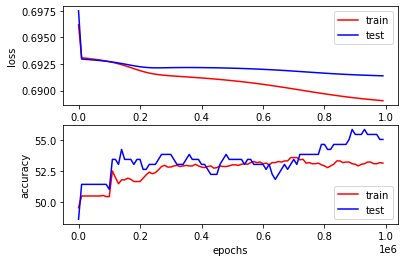

In [35]:
# ------------------- PLOT RESULTS -------------------
fig, (ax1, ax2) = plt.subplots(2, 1)

t = np.arange(epochs, step=step)

ax1.plot(t, losses,'r', label='train')
ax1.plot(t, losses_test, 'b', label='test')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(t, acc,'r', label='train')
ax2.plot(t, acc_test, 'b', label='test')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.legend()
